# This code loads the pilot screen data, assign cells to guides, and create the object Rd1_Data_post_sgRNA_rescue-reseq.h5ad

In [1]:
import pandas as pd
from pathlib import Path
import json

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import re
import dask.dataframe as dd
import anndata as ad
from anndata import AnnData
#import relation_data_lake as rdl
import scipy.sparse as sp
import scanpy as sc

In [4]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

DIR_DATA_RNA = "../../data_raw/rna/"
DIR_DATA_GENERATED = Path("../../data_generated")
DIR_PLOTS = Path("../../plots")

In [5]:
fibro_processed_names = [
    'GSM8151750_Activated_OP1L_NM_NA_Rep1',
    'GSM8151751_Activated_OP1L_NM_NA_Rep2',
    'GSM8151752_Quiescent_OP1L_NM_NA_Rep1',
    'GSM8151753_Quiescent_OP1L_NM_NA_Rep2'
]

In [6]:
cell2guides = []
for fibro_processed_name in fibro_processed_names:
    f_path = (DIR_DATA_RNA + fibro_processed_name + '_protospacer_calls_per_cell.csv.gz')
    cell2guide = pd.read_csv(f_path, index_col='cell_barcode').drop(columns = ['num_features'])
    cell2guide = cell2guide.apply(lambda col: col.str.split('|'))
    cell2guide = cell2guide.apply(pd.Series.explode)
    cell2guide = cell2guide.pivot(columns='feature_call', values='num_umis').fillna(0)
    cell2guide.index = cell2guide.index + '-' + fibro_processed_name.split('_', 1)[1]
    #print(cell2guide.columns)
    cell2guides.append(cell2guide)

In [7]:
cell2guides = pd.concat(cell2guides) # .astype(int)
cell2guides[pd.isna(cell2guides)] = 0
cell2guides = cell2guides.astype(int)
counts_matrix = cell2guides.copy()

# Step 1: Filter low expressed counts that represent only a small fraction of total counts.

In [8]:
freq_matrix = counts_matrix / counts_matrix.sum(axis=1).values[:,None]
log_freq_matrix = np.log10( 1 + counts_matrix ) / np.log10(1 + counts_matrix.sum(axis=1).values[:,None] )

df = pd.DataFrame(data={'cell_id':np.tile(counts_matrix.index,(1,counts_matrix.shape[1])).flatten(),
                        'total_counts': np.tile(counts_matrix.sum(axis=1),(1,counts_matrix.shape[1])).flatten(),
                        'log_total_counts': np.log10( np.tile(counts_matrix.sum(axis=1),(1,counts_matrix.shape[1])).flatten() ),
                        'freq': np.ravel(freq_matrix.values.T),
                        'log_freq': np.ravel(log_freq_matrix.values.T),
                        'sgRNA_counts': np.ravel(counts_matrix.values.T),
                        'log_sgRNA_counts': np.log10( np.ravel(counts_matrix.values.T) )
                       })
df

/tmp/ipykernel_8915/234126711.py:10: RuntimeWarning: divide by zero encountered in log10
  'log_sgRNA_counts': np.log10( np.ravel(counts_matrix.values.T) )


,cell_id,total_counts,log_total_counts,freq,log_freq,sgRNA_counts,log_sgRNA_counts
0,AAACCCAAGAATCGTA-1-Activated_OP1L_NM_NA_Rep1,150,2.176091,0.0,0.0,0,-inf
1,AAACCCAAGAGGATCC-1-Activated_OP1L_NM_NA_Rep1,240,2.380211,0.0,0.0,0,-inf
2,AAACCCAAGATAACGT-1-Activated_OP1L_NM_NA_Rep1,197,2.294466,0.0,0.0,0,-inf
3,AAACCCAAGATCCCAT-1-Activated_OP1L_NM_NA_Rep1,80,1.903090,0.0,0.0,0,-inf
4,AAACCCACAGATCCAT-1-Activated_OP1L_NM_NA_Rep1,27,1.431364,0.0,0.0,0,-inf
...,...,...,...,...,...,...,...
409803,TTTGGTTCATCGGATT-1-Quiescent_OP1L_NM_NA_Rep2,35,1.544068,0.0,0.0,0,-inf
409804,TTTGGTTGTCTGGTTA-1-Quiescent_OP1L_NM_NA_Rep2,556,2.745075,0.0,0.0,0,-inf
409805,TTTGTTGCATCAACCA-1-Quiescent_OP1L_NM_NA_Rep2,91,1.959041,0.0,0.0,0,-inf
409806,TTTGTTGGTCGCAACC-1-Quiescent_OP1L_NM_NA_Rep2,44,1.643453,0.0,0.0,0,-inf


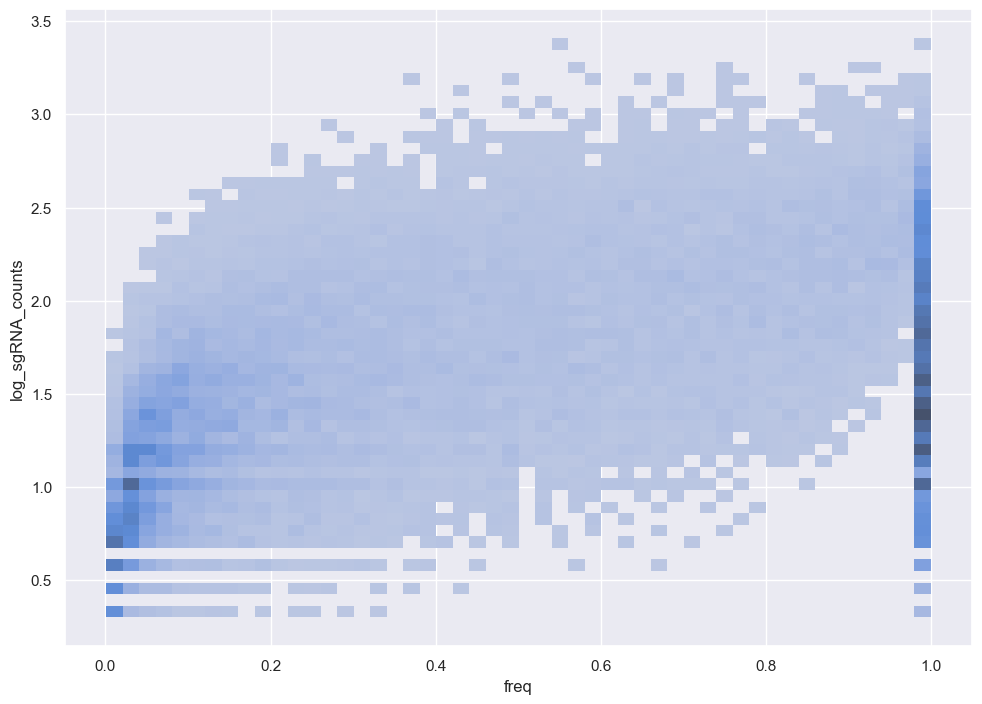

<Figure size 1170x827 with 0 Axes>

In [9]:
sns.histplot(
    data=df[df.log_sgRNA_counts > 0], x = 'freq', y = 'log_sgRNA_counts', bins=50
)

plt.savefig(DIR_PLOTS / "sgRNA_density_plot_Rd1", dpi=400)
plt.show()
plt.clf()

In [10]:
counts_matrix_filtered = counts_matrix.copy()
counts_matrix_filtered[(freq_matrix <= 0.175) & (counts_matrix <= 10**1.75)] = 0

In [11]:
freq_matrix = counts_matrix_filtered / counts_matrix_filtered.sum(axis=1).values[:,None]
log_freq_matrix = np.log10( 1 + counts_matrix_filtered ) / np.log10(1 + counts_matrix_filtered.sum(axis=1).values[:,None] )

df = pd.DataFrame(data={'cell_id':np.tile(counts_matrix_filtered.index,(1,counts_matrix.shape[1])).flatten(),
                        'total_counts': np.tile(counts_matrix_filtered.sum(axis=1),(1,counts_matrix.shape[1])).flatten(),
                        'log_total_counts': np.log10( np.tile(counts_matrix_filtered.sum(axis=1),(1,counts_matrix.shape[1])).flatten() ),
                        'freq': np.ravel(freq_matrix.values.T),
                        'log_freq': np.ravel(log_freq_matrix.values.T),
                        'sgRNA_counts': np.ravel(counts_matrix_filtered.values.T),
                        'log_sgRNA_counts': np.log10( np.ravel(counts_matrix_filtered.values.T) )
                       })

/tmp/ipykernel_8915/3084429904.py:10: RuntimeWarning: divide by zero encountered in log10
  'log_sgRNA_counts': np.log10( np.ravel(counts_matrix_filtered.values.T) )


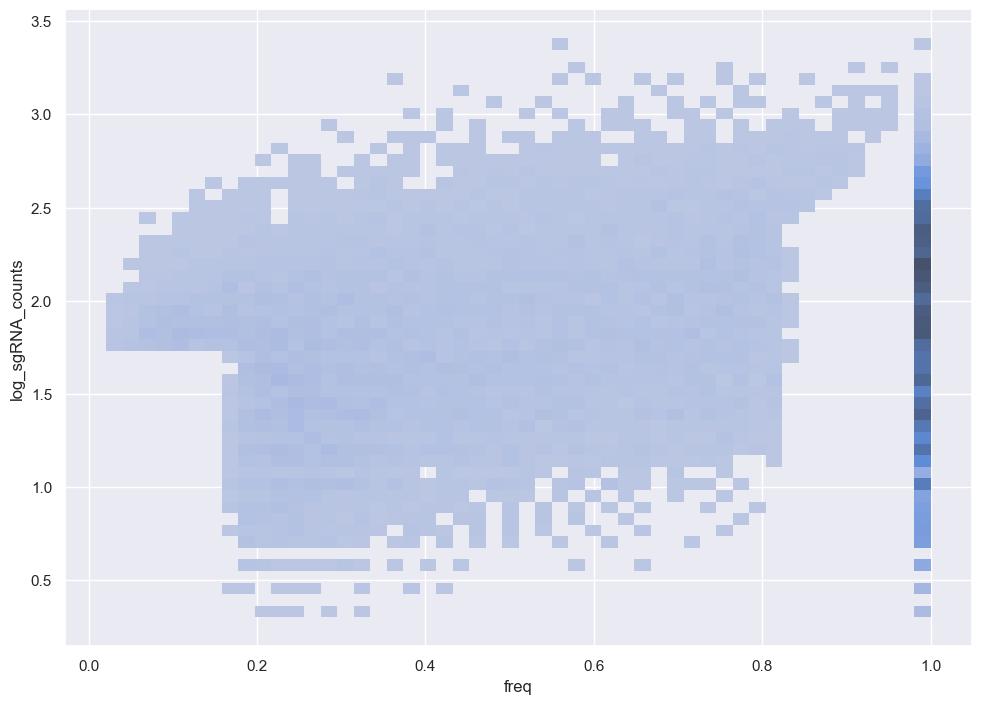

<Figure size 1170x827 with 0 Axes>

In [12]:
sns.histplot(
    data=df[df.log_sgRNA_counts > 0], x = 'freq', y = 'log_sgRNA_counts', bins=50
)

plt.savefig(DIR_PLOTS / "sgRNA_density_plot_filtered_Rd1", dpi=400)
plt.show()
plt.clf()

# Step 2: Map MOI=2 cells to MOI=1 when sgRNAs correspond to same gene, or with a targeting gene & NTC

In [13]:
def combine_columns_and_delete(counts_matrix_filtered, col1, col2, new_col):
    counts_matrix_filtered[new_col] = counts_matrix_filtered[col1] + counts_matrix_filtered[col2]
    counts_matrix_filtered = counts_matrix_filtered.drop(columns=[col1, col2])
    return counts_matrix_filtered

In [14]:
counts_matrix_filtered.columns

Index(['Arid2_As_73066', 'Arid2_As_73067', 'Brd7_As_70316', 'Brd9_As_70306',
       'Brd9_As_70308', 'Dmap1_As_60922', 'Hcfc1_As_49709', 'Hcfc1_As_49711',
       'Ino80_As_46860', 'Kansl1_As_45908', 'Kansl1_As_45909', 'Kat5_Br_45092',
       'Kat5_Br_45093', 'Kat8_As_45860', 'Kat8_As_45861', 'NTC_0005',
       'NTC_0006', 'Pbrm1_As_28642', 'Pbrm1_As_28643', 'Smad4_1',
       'Smarcd1_As_15167', 'Smarcd1_Br_45407', 'Srcap_As_77988', 'TGFbR_3',
       'Wdr82_As_3096', 'Wdr82_As_3097', 'Yy1_As_2359', 'Znhit1_As_222'],
      dtype='object', name='feature_call')

In [16]:
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'NTC_0005','NTC_0006','non-targeting')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Arid2_As_73066', 'Arid2_As_73067','Arid2')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Brd9_As_70306','Brd9_As_70308','Brd9')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Hcfc1_As_49709', 'Hcfc1_As_49711','Hcfc1')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Kansl1_As_45908', 'Kansl1_As_45909','Kansl1')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Kat5_Br_45092','Kat5_Br_45093','Kat5')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Kat8_As_45860', 'Kat8_As_45861','Kat8')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered, 'Pbrm1_As_28642','Pbrm1_As_28643','Pbrm1')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Smarcd1_As_15167', 'Smarcd1_Br_45407','Smarcd1')
counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Wdr82_As_3096', 'Wdr82_As_3097','Wdr82')

counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'Smad4_1','Smad4_3','Smad4')

counts_matrix_filtered = combine_columns_and_delete(counts_matrix_filtered,'TGFbR_1','TGFbR_3','Tgfbr1')

counts_matrix_filtered = counts_matrix_filtered.rename(columns={"Brd7_As_70316":"Brd7","Dmap1_As_60922":"Dmap1",
                                                                "Ino80_As_46860":"Ino80", "Srcap_As_77988":"Srcap",
                                                                "Yy1_As_2359":"Yy1","Znhit1_As_222":"Znhit1"})

KeyError: 'Arid2_As_73066'

In [ ]:
counts_matrix_filtered.columns

In [ ]:
counts_matrix_filtered.sum()

In [ ]:
MOI1_cells = counts_matrix_filtered[(counts_matrix_filtered >0).apply(lambda row: sum(row)==1, axis=1)]
MOI2_cells = counts_matrix_filtered[(counts_matrix_filtered >0).apply(lambda row: sum(row)==2, axis=1)]

In [ ]:
MOI2_cells['non-targeting'] = 0
MOI1_rescue = MOI2_cells[(MOI2_cells >0).apply(lambda row: sum(row)==1, axis=1)]

In [ ]:
cells_to_keep = pd.concat([MOI1_cells, MOI1_rescue])
cells_to_keep['target_max'] = cells_to_keep.idxmax(axis=1)
cells_to_keep = cells_to_keep.drop(columns=counts_matrix_filtered.columns.unique())


In [ ]:
cells_to_keep

In [ ]:
cells_to_keep['cell_barcode_corrected'] = 0
cells_to_keep['cell_barcode_old'] = cells_to_keep.index
cells_to_keep['condition'] = 'NaN'
cells_to_keep['batch'] = 'NaN'
for cb in cells_to_keep.index:
    if 'Quiescent' in cb:
        state1 = 'Resting'
        if 'Rep1' in cb:
            state2 = 'Rep1-Resting'
        else:
            state2 = 'Rep2-Resting'
    if 'Activated' in cb:
        state1 = 'Tgfb1'
        if 'Rep1' in cb:
            state2 = 'Rep3-Tgfb1'
        else:
            state2 = 'Rep4-Tgfb1'
    cells_to_keep['condition'].loc[cb] = state1
    cells_to_keep['batch'].loc[cb] = state2
    cells_to_keep['cell_barcode_corrected'].loc[cb] = cb[0:16] + '-' + state2
    cells_to_keep['cell_barcode_old'].loc[cb] = cb[0:18]
cells_to_keep = cells_to_keep.set_index('cell_barcode_corrected')


In [ ]:
cells_to_keep.batch.unique()

In [ ]:
cells_to_keep.groupby(['batch']).count()

# Step 3: Select cells and merge into adata object

In [17]:
adata_rep1 = sc.read_10x_h5(DIR_DATA_RNA / 'Quiescent_OP1L_NM_NA_Rep1/outs/filtered_feature_bc_matrix.h5')
adata_rep2 = sc.read_10x_h5(DIR_DATA_RNA / 'Quiescent_OP1L_NM_NA_Rep2/outs/filtered_feature_bc_matrix.h5')
adata_rep3 = sc.read_10x_h5(DIR_DATA_RNA / 'Activated_OP1L_NM_NA_Rep1/outs/filtered_feature_bc_matrix.h5')
adata_rep4 = sc.read_10x_h5(DIR_DATA_RNA / 'Activated_OP1L_NM_NA_Rep2/outs/filtered_feature_bc_matrix.h5')

/home/wolfgang/Programs/miniforge3/envs/fibroblasts/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wolfgang/Programs/miniforge3/envs/fibroblasts/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wolfgang/Programs/miniforge3/envs/fibroblasts/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wolfgang/Programs/miniforge3/envs/fibroblasts/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wolfgang/Progr

In [ ]:
batch_adatas = {'Rep1-Resting':adata_rep1,
                'Rep2-Resting':adata_rep2,
                'Rep3-Tgfb1':adata_rep3,
                'Rep4-Tgfb1':adata_rep4
               }

In [ ]:
for ii in batch_adatas.keys():
    print(ii)
    adata_tmp = batch_adatas[ii].copy()
    cells_to_keep_tmp = cells_to_keep[cells_to_keep.batch == ii].copy()
    cells_to_keep_tmp.reset_index(inplace=True)
    cells_to_keep_tmp.set_index('cell_barcode_old', inplace=True)
    adata_tmp = adata_tmp[adata_tmp.obs.index.isin(cells_to_keep_tmp.index),:]
    adata_tmp.obs = pd.concat([adata_tmp.obs, cells_to_keep_tmp], axis=1).reindex(adata_tmp.obs.index)
    adata_tmp.obs.set_index('cell_barcode_corrected', inplace=True)
    adata_tmp.var.index.name = 'original_name'
    adata_tmp.obs_names_make_unique()
    adata_tmp.var_names_make_unique()
    batch_adatas[ii] = adata_tmp

In [ ]:
adata = ad.concat(batch_adatas, axis = 0)

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'

In [ ]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [ ]:
adata.obs['target'] = adata.obs['target_max']
adata.obs.drop(columns=['target_max'], inplace=True)

In [ ]:
adata.obs.groupby(['condition','batch']).count()

In [ ]:
adata.write_h5ad(DIR_DATA_GENERATED / 'Rd1_Data_post_sgRNA_rescue-reseq.h5ad.gzip', compression='gzip')